In [2]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])

import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [278]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Number of fiscal households,Number of taxed households,Mean reference fiscal income (in k€),food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,...,Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City,Department,Region,Arrondissement
0,206,108,27.468762,431441,16.0,16.0,4,NaN,883.0,12.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
1,206,108,27.468762,348749,15.0,15.0,4,NaN,703.0,9.30,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
2,206,108,27.468762,348720,16.0,16.0,4,NaN,900.0,12.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
3,206,108,27.468762,348741,11.0,11.0,4,50 g (1 tranche),514.0,3.66,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
4,206,108,27.468762,348708,15.0,15.0,4,Une tranche 100 g,699.0,9.40,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004


# 0. Distribution of the nutrition grades at each geographical level for the richest and poorest zone

In [279]:
def analyse_for_area(df, area_column, area_name):
    revenue = df.groupby(area_column).mean().sort_values(by=['Median revenue euros'], ascending=False)
    rich = revenue.iloc[[0]]
    rich.reset_index(inplace=True)
    poor = revenue.iloc[[-1]]
    poor.reset_index(inplace=True)
    
    departments = [list(rich[area_column].values)[0], list(poor[area_column].values)[0]]
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                     'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                     'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    
    dummies = pd.get_dummies(df, columns=['nutrition_grade_numeric']).groupby(area_column).sum()
    dummies.reset_index(inplace=True)
    dummies = dummies[dummies[area_column].apply(lambda x: x in departments)][list_dummy_grades]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for the richest and the poorest {}".format(area_name),
                 y=1.08, fontweight="bold")
    dummies.iloc[[0]].plot.bar(ax=ax1, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    dummies.iloc[[1]].plot.bar(ax=ax2, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    ax1.set_title("Rich {}".format(area_name))
    ax2.set_title("Poor {}".format(area_name))

    plt.show()

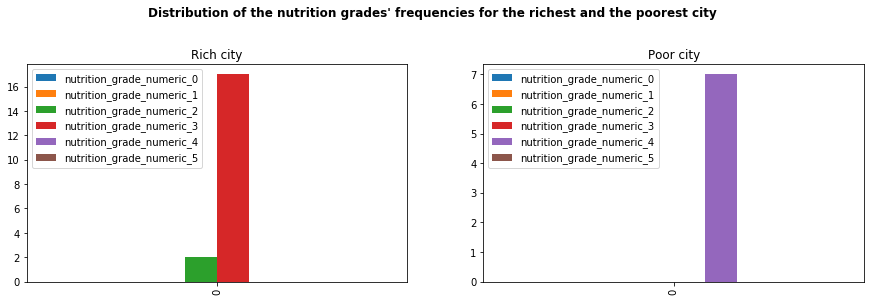

In [280]:
analyse_for_area(dataframe, 'City name', 'city')

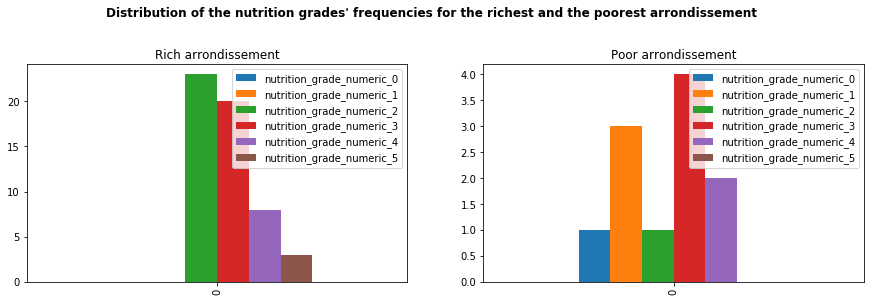

In [281]:
analyse_for_area(dataframe, 'custom_arrondissement_code', 'arrondissement')

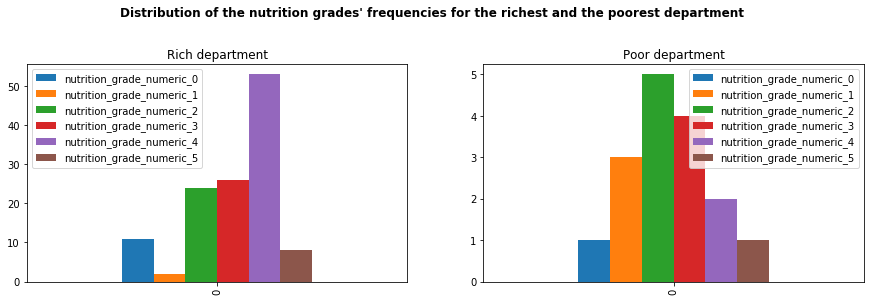

In [282]:
analyse_for_area(dataframe, 'Department', 'department')

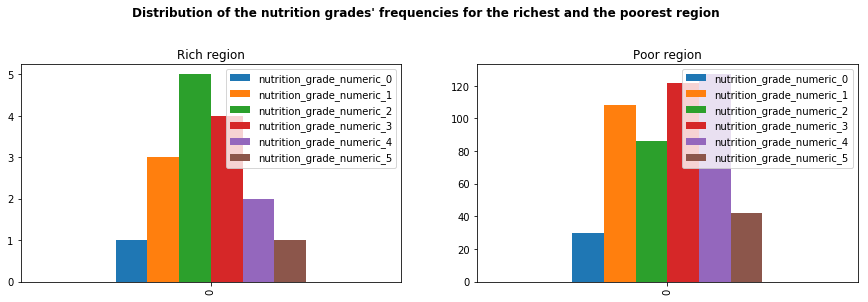

In [283]:
analyse_for_area(dataframe, 'Region', 'region')

# 1. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

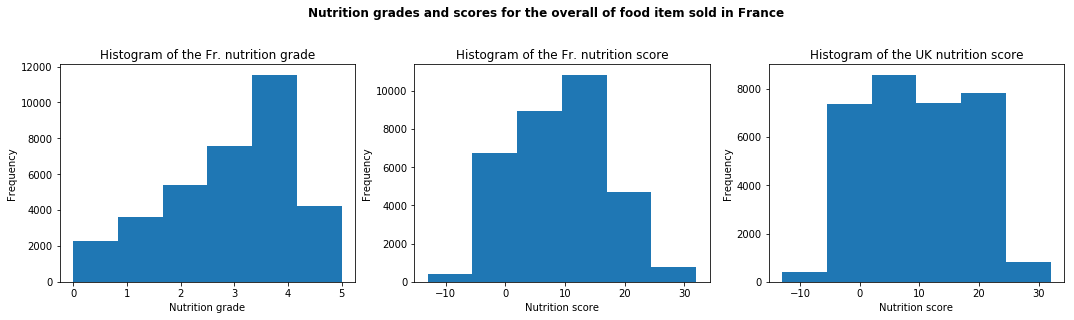

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

*Reminder: `0` is equivalent to no data.*

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will select only the relevant columns in our dataframe (i.e. columns that don't have the **exact same information**, columns that are not **redundant**, or columns that have **enough non NaN values**). 

# 2. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving size) and calory deviation.

Calory deviation is computed according to the nutritional standards that the calories that we consume in a day should be composed of $21 \%$ from protein, $53 \%$ from carbohydrates and $26 \%$ from fat. We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat. 

In [284]:
# we consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g', 'serving_size']]
# we drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# we keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# we remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# we cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:, 'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins --> 21% of cals, 4 cals/g

Carbohydrates --> 53% of cals, 4 cals/g

Fat --> 26% of cals, 9 cals/g

In [285]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26)**2 + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53)**2 +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21)**2)/3
# we remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    21376.000000
mean         5.766193
std        563.562554
min          0.000044
25%          0.017735
50%          0.078327
75%          0.160257
max      58205.149533
dtype: float64

In [286]:
# we insert our columns in our dataframe
dataframe.loc[:, 'cal_density'] = cal_density
dataframe.loc[:, 'cal_deviation'] = cal_deviation
dataframe.head()

,Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),city_tag,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,...,Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code,city_name,city_tag_from_food_item,cal_density,cal_deviation
0,206,108,27.468762,apremont,431441,16.0,16.0,4,NaN,883.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.133987
1,206,108,27.468762,apremont,348749,15.0,15.0,4,NaN,703.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.116812
2,206,108,27.468762,apremont,348720,16.0,16.0,4,NaN,900.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,NaN,0.130923
3,206,108,27.468762,apremont,348741,11.0,11.0,4,50.0,514.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,257.0,0.157268
4,206,108,27.468762,apremont,348708,15.0,15.0,4,100.0,699.0,...,NaN,NaN,Apremont,10,84,1004,apremont,apremont-vendee-france,699.0,0.117324


# 3. Decide which columns to keep

In [287]:
numeric_cols = ['Number of fiscal households', 'Number of taxed households', 
                'Mean reference fiscal income (in k€)', 'food_item_index', 'nutrition-score-fr_100g', 
                'nutrition-score-uk_100g','nutrition_grade_numeric', 'serving_size', 'energy_100g', 
                'fat_100g','saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
                'fiber_100g', 'Median revenue euros','Total poverty rate (%)', 'Poverty rate (-30) (%)',
               'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
               'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
               'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
               'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
               'Share of retreat pension revenue (%)',
               'Share of heritage revenue and other (%)',
               'Share of social benefits revenue (%)', 'Share of taxes (%)',
               'cal_density', 'cal_deviation']

In [288]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<55%}'.format(column, 'Number of non-na:', nonna))

Nombre de foyers fiscaux                     Number of non-na:             100.000000%                                            
Nombre de foyers fiscaux imposés             Number of non-na:             100.000000%                                            
Mean reference fiscal income (in k€)         Number of non-na:             100.000000%                                            
food_item_index                              Number of non-na:             100.000000%                                            
nutrition-score-fr_100g                      Number of non-na:             93.127226%                                             
nutrition-score-uk_100g                      Number of non-na:             93.127226%                                             
nutrition_grade_numeric                      Number of non-na:             100.000000%                                            
serving_size                                 Number of non-na:             55.44798

We decided to keep all nutritional columns and all economical columns that have at least $90 \%$ of non NaN values. Indeed, all nutritional columns are probably useful for our analysis, however if we keep economical columns that have a lot of NaN values within them, we will lose information when we use dropna(). Moreover, we assume that the informaiton about the revenue conveys all the economical information we need (since it is closely linked with all the other economic features such as poverty rate, etc).

We also decided to drop the column 'Number of taxed households" because it seems to be redundant with respect to 'Number of fiscal households'. 

This leaves us with:

* 1 column describing the food item's identifier:
    - food item index

* 11 columns describing nutritional features:
    - nutrition-score-fr_100g            
    - nutrition-score-uk_100g            
    - nutrition_grade_numeric           
    - serving_size           
    - energy_100g                        
    - fat_100g                           
    - saturated-fat_100g                 
    - proteins_100g                      
    - carbohydrates_100g                 
    - sugars_100g                        
    - fiber_100g

* 3 columns describing economic features: 
    - Median revenue euros
    - Mean reference fiscal income (in k€) 
    - Number of fiscal households
    
* 4 columns describing geographical features
    - City
    - Arrondissement
    - Department
    - Region

In [120]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros', 'Mean reference fiscal income (in k€)', 'Number of fiscal households', 
                       'Number of taxed households', 'City', 'Department', 
                       'Region', 'Arrondissement']]

# 4. Aggregation

In [45]:
dataframe['total_revenue_area'] = dataframe['Number of fiscal households'] * \
                                  dataframe['Mean reference fiscal income (in k€)']

We have to remove the DOM-TOMS since the cultural differences are too large (Guadeloupe, Guyane, etc).

In [121]:
dom_tom = [1, 2, 4]
dataframe['Region'] = dataframe['Region'][dataframe['Region'].apply(lambda x: x not in dom_tom)]

In [43]:
nutritional_columns = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation']
economic_columns = ['Number of fiscal households', 'Number of taxed households',
                    'Mean reference fiscal income (in k€)', 'Median revenue euros', 'total_revenue_area']

def aggregate(area_column):
    # aggregate the nutritional information
    aggregated_nutritional = dataframe[
        [area_column] + nutritional_columns
    ].dropna().groupby(area_column).agg(['mean', 'median'])
    # aggregate income information
    aggregated_income = dataframe[
        [area_column] + economic_columns
    ].dropna().drop_duplicates().groupby(area_column).agg({
        'Median revenue euros': ['mean', 'median'],
        **{column: 'sum' for column in economic_columns if column != 'Median revenue euros'}
    })
    aggregated_income['Mean reference fiscal income (in k€)'] = aggregated_income['total_revenue_area'] \
                                                                / aggregated_income['Number of fiscal households']
    return aggregated_nutritional.merge(aggregated_income, on=area_column)

In [175]:
aggregated_city = aggregate('City')
aggregated_city.head()

,"(nutrition-score-fr_100g, mean)","(nutrition-score-fr_100g, median)","(nutrition-score-uk_100g, mean)","(nutrition-score-uk_100g, median)","(nutrition_grade_numeric, mean)","(nutrition_grade_numeric, median)","(serving_size, mean)","(serving_size, median)","(energy_100g, mean)","(energy_100g, median)",...,"(fiber_100g, mean)","(fiber_100g, median)","(cal_density, mean)","(cal_density, median)","(cal_deviation, mean)","(cal_deviation, median)",Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),total_revenue_area
City name,,,,,,,,,,,,,,,,,,,,,
Abbeville,0.2,0.0,0.2,0.0,2.0,2.0,260.00,250.0,204.2,192.0,...,0.160,0.00,528.60,480.0,0.011563,0.006700,14419,4408,18.691631,269514.626
Ablis,2.5,2.5,2.5,2.5,2.5,2.5,223.75,235.0,486.0,493.0,...,1.175,0.85,1106.65,1106.3,0.067953,0.067282,1702,953,32.541324,55385.333
Acigné,0.0,0.0,0.0,0.0,2.0,2.0,100.00,100.0,192.0,192.0,...,0.000,0.00,192.00,192.0,0.006700,0.006700,3391,1827,32.280033,109461.592
Acquigny,-4.0,-4.0,-4.0,-4.0,1.0,1.0,330.00,330.0,406.0,406.0,...,3.800,3.80,1339.80,1339.8,0.092305,0.092305,862,439,30.560187,26342.881
Agencourt,-6.0,-6.0,-6.0,-6.0,1.0,1.0,250.00,250.0,1452.0,1452.0,...,13.900,13.90,3630.00,3630.0,0.031904,0.031904,223,114,28.173507,6282.692


In [178]:
aggregated_arrondissement = aggregate('Arrondissement')
aggregated_arrondissement.head()

,"(nutrition-score-fr_100g, mean)","(nutrition-score-fr_100g, median)","(nutrition-score-uk_100g, mean)","(nutrition-score-uk_100g, median)","(nutrition_grade_numeric, mean)","(nutrition_grade_numeric, median)","(serving_size, mean)","(serving_size, median)","(energy_100g, mean)","(energy_100g, median)",...,"(fiber_100g, mean)","(fiber_100g, median)","(cal_density, mean)","(cal_density, median)","(cal_deviation, mean)","(cal_deviation, median)",Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),total_revenue_area
custom_arrondissement_code,,,,,,,,,,,,,,,,,,,,,
1001,12.833333,12.5,13.666667,12.5,4.000000,4.0,120.833333,125.0,837.333333,834.0,...,0.750000,0.95,1046.000000,1042.50,0.119184,0.147307,10453,4445,23.928125,250120.690
1002,12.216867,13.0,12.433735,13.0,3.626506,4.0,185.445783,125.0,1276.096386,1031.0,...,2.050723,2.00,2504.815783,1277.90,0.040714,0.020312,48420,22101,25.432726,1231452.611
1004,3.500000,2.5,3.500000,2.5,2.500000,2.5,119.375000,137.5,1100.750000,1102.5,...,1.950000,2.20,1255.675000,1544.25,0.036099,0.024938,11137,4207,24.811527,276325.981
2001,1.857143,3.0,1.857143,3.0,2.285714,3.0,125.000000,125.0,345.571429,389.0,...,0.171429,0.10,431.964286,486.25,0.006890,0.003882,2410,1189,27.403263,66041.865
2002,1.970588,1.0,1.970588,1.0,2.058824,2.0,276.676471,220.0,698.617647,491.5,...,1.900000,1.80,2123.977647,1640.00,0.010725,0.001543,17605,5698,18.389409,323745.547


In [50]:
aggregated_department = aggregate('Department')
aggregated_department.head()

,"(nutrition-score-fr_100g, mean)","(nutrition-score-fr_100g, median)","(nutrition-score-uk_100g, mean)","(nutrition-score-uk_100g, median)","(nutrition_grade_numeric, mean)","(nutrition_grade_numeric, median)","(serving_size, mean)","(serving_size, median)","(energy_100g, mean)","(energy_100g, median)",...,"(fiber_100g, mean)","(fiber_100g, median)","(cal_density, mean)","(cal_density, median)","(cal_deviation, mean)","(cal_deviation, median)",Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),total_revenue_area
Department,,,,,,,,,,,,,,,,,,,,,
10,11.536082,12.0,11.773196,12.0,3.556701,4,176.000000,125.0,1234.494845,1029.0,...,1.961959,1.9,2311.557835,1224.45,0.045187,0.022428,71042,31131,25.340080,1800209.934
20,4.881657,3.0,4.846154,3.0,2.562130,3,104.585799,45.0,1233.597633,1582.0,...,3.588225,3.2,913.924911,550.25,0.027782,0.019467,27502,9480,19.830961,545391.090
30,3.000000,0.0,3.000000,0.0,2.384615,2,141.076923,130.0,819.461538,632.0,...,2.975638,0.1,929.573077,622.80,0.057960,0.030097,53589,19557,20.415973,1094071.573
40,1.500000,0.0,1.500000,0.0,2.125000,2,76.375000,83.0,1176.875000,1560.5,...,4.775000,4.5,681.496250,543.51,0.025333,0.018389,16696,6585,24.218468,404351.538
50,0.000000,0.0,0.000000,0.0,1.909091,2,295.727273,30.0,1687.545455,1565.0,...,4.781818,3.9,2748.897273,774.60,0.072337,0.045014,28755,12289,24.595729,707250.185


In [51]:
aggregated_region = aggregate('Region')
aggregated_region.head()

,"(nutrition-score-fr_100g, mean)","(nutrition-score-fr_100g, median)","(nutrition-score-uk_100g, mean)","(nutrition-score-uk_100g, median)","(nutrition_grade_numeric, mean)","(nutrition_grade_numeric, median)","(serving_size, mean)","(serving_size, median)","(energy_100g, mean)","(energy_100g, median)",...,"(fiber_100g, mean)","(fiber_100g, median)","(cal_density, mean)","(cal_density, median)","(cal_deviation, mean)","(cal_deviation, median)",Nombre de foyers fiscaux,Nombre de foyers fiscaux imposés,Mean reference fiscal income (in k€),total_revenue_area
Region,,,,,,,,,,,,,,,,,,,,,
11.0,4.254545,3.0,4.090909,2.5,2.500000,3,170.172727,100.0,890.736364,816.0,...,2.506909,2.0,1370.977545,654.50,0.056276,0.038546,695296,326402,25.632209,1.782197e+07
24.0,6.652336,6.0,5.297196,3.0,3.014953,3,127.254206,100.0,999.452336,728.0,...,2.440318,1.1,795.629944,483.30,0.124079,0.035984,301148,128649,23.796706,7.166330e+06
27.0,6.420804,4.0,6.773050,4.0,2.848700,3,155.354610,100.0,792.605201,573.0,...,1.041915,0.4,1291.889314,460.00,0.057605,0.031642,370931,163727,23.883883,8.859272e+06
28.0,5.763668,3.0,5.943563,3.0,2.776014,3,179.299824,100.0,996.793651,695.0,...,2.047053,1.3,1639.630882,644.80,0.056278,0.026419,251016,96147,21.827763,5.479118e+06
32.0,7.264451,6.0,7.401734,6.0,3.013006,3,112.250000,85.0,1008.323410,935.5,...,2.064159,1.2,856.878078,582.45,0.068517,0.033699,351591,121223,20.721233,7.285399e+06


# 5. Clustering

In [124]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

**1. Cities**

In [189]:
def plot_scatter(df):
    fig, axs = plt.subplots(4, 4, figsize=(25, 25))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutritional_columns:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.delaxes(axs[3, 1])
    fig.delaxes(axs[3, 2])
    fig.delaxes(axs[3, 3])
    fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


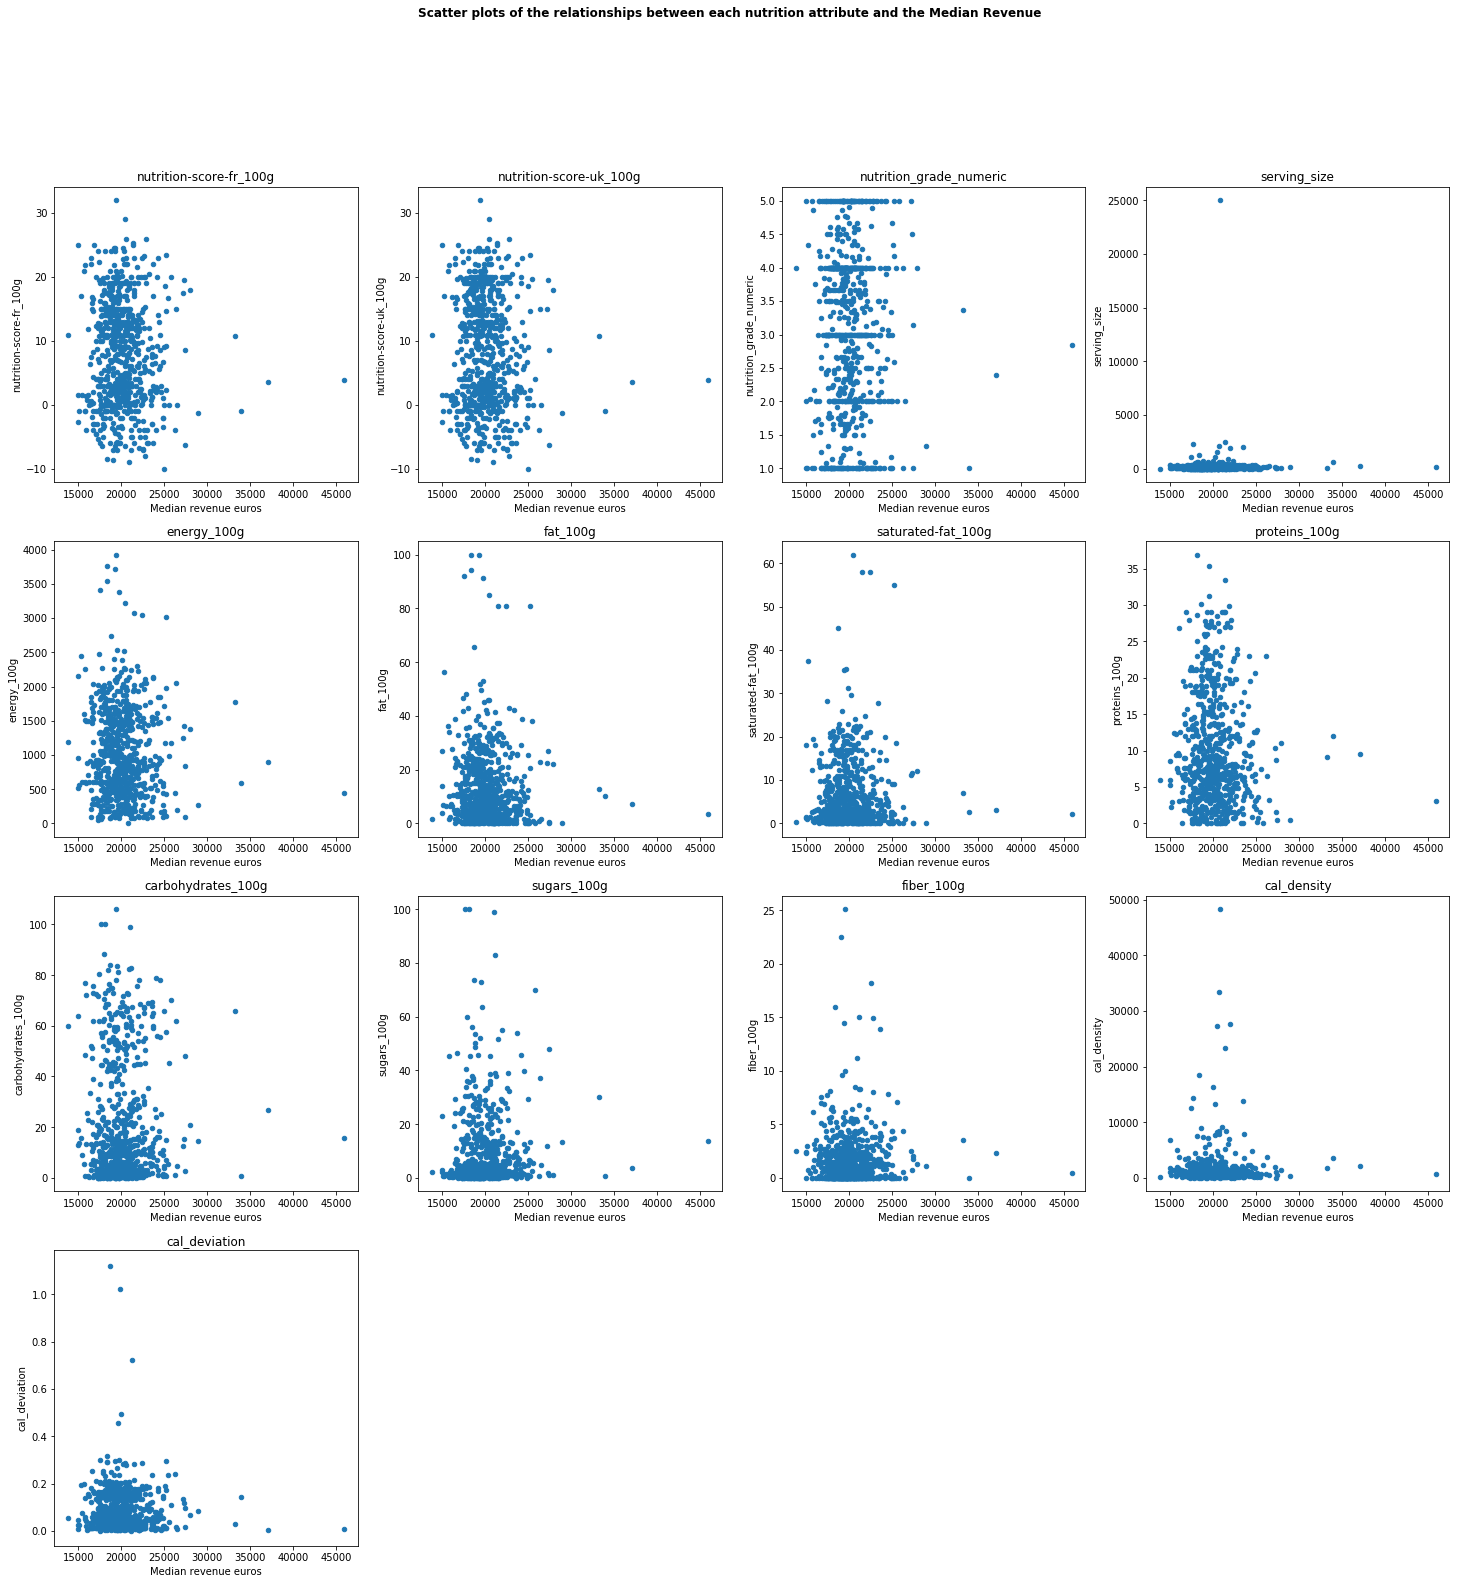

In [190]:
plot_scatter(dataframe_city)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


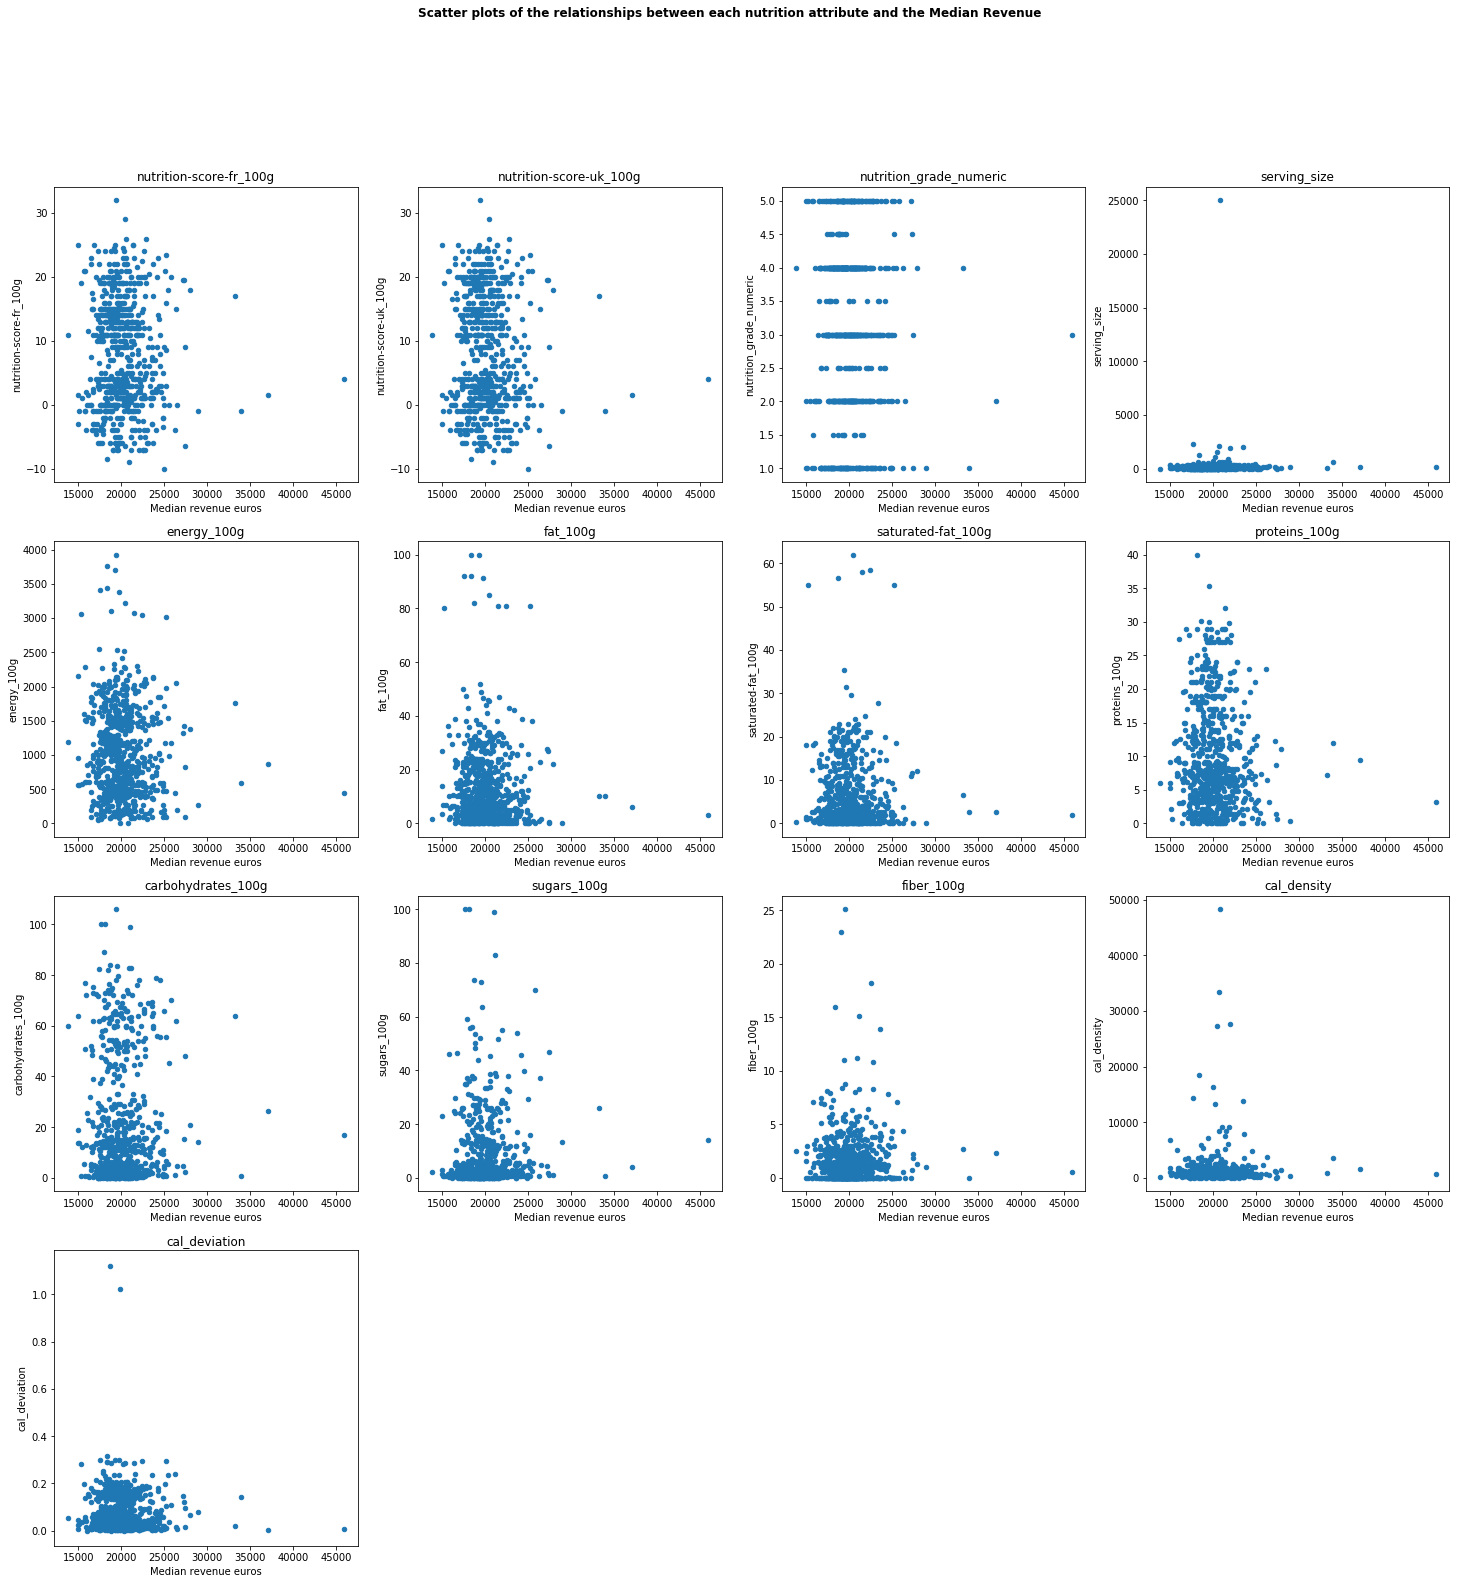

In [191]:
plot_scatter(dataframe_city_med)

**2. Arrondissements**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


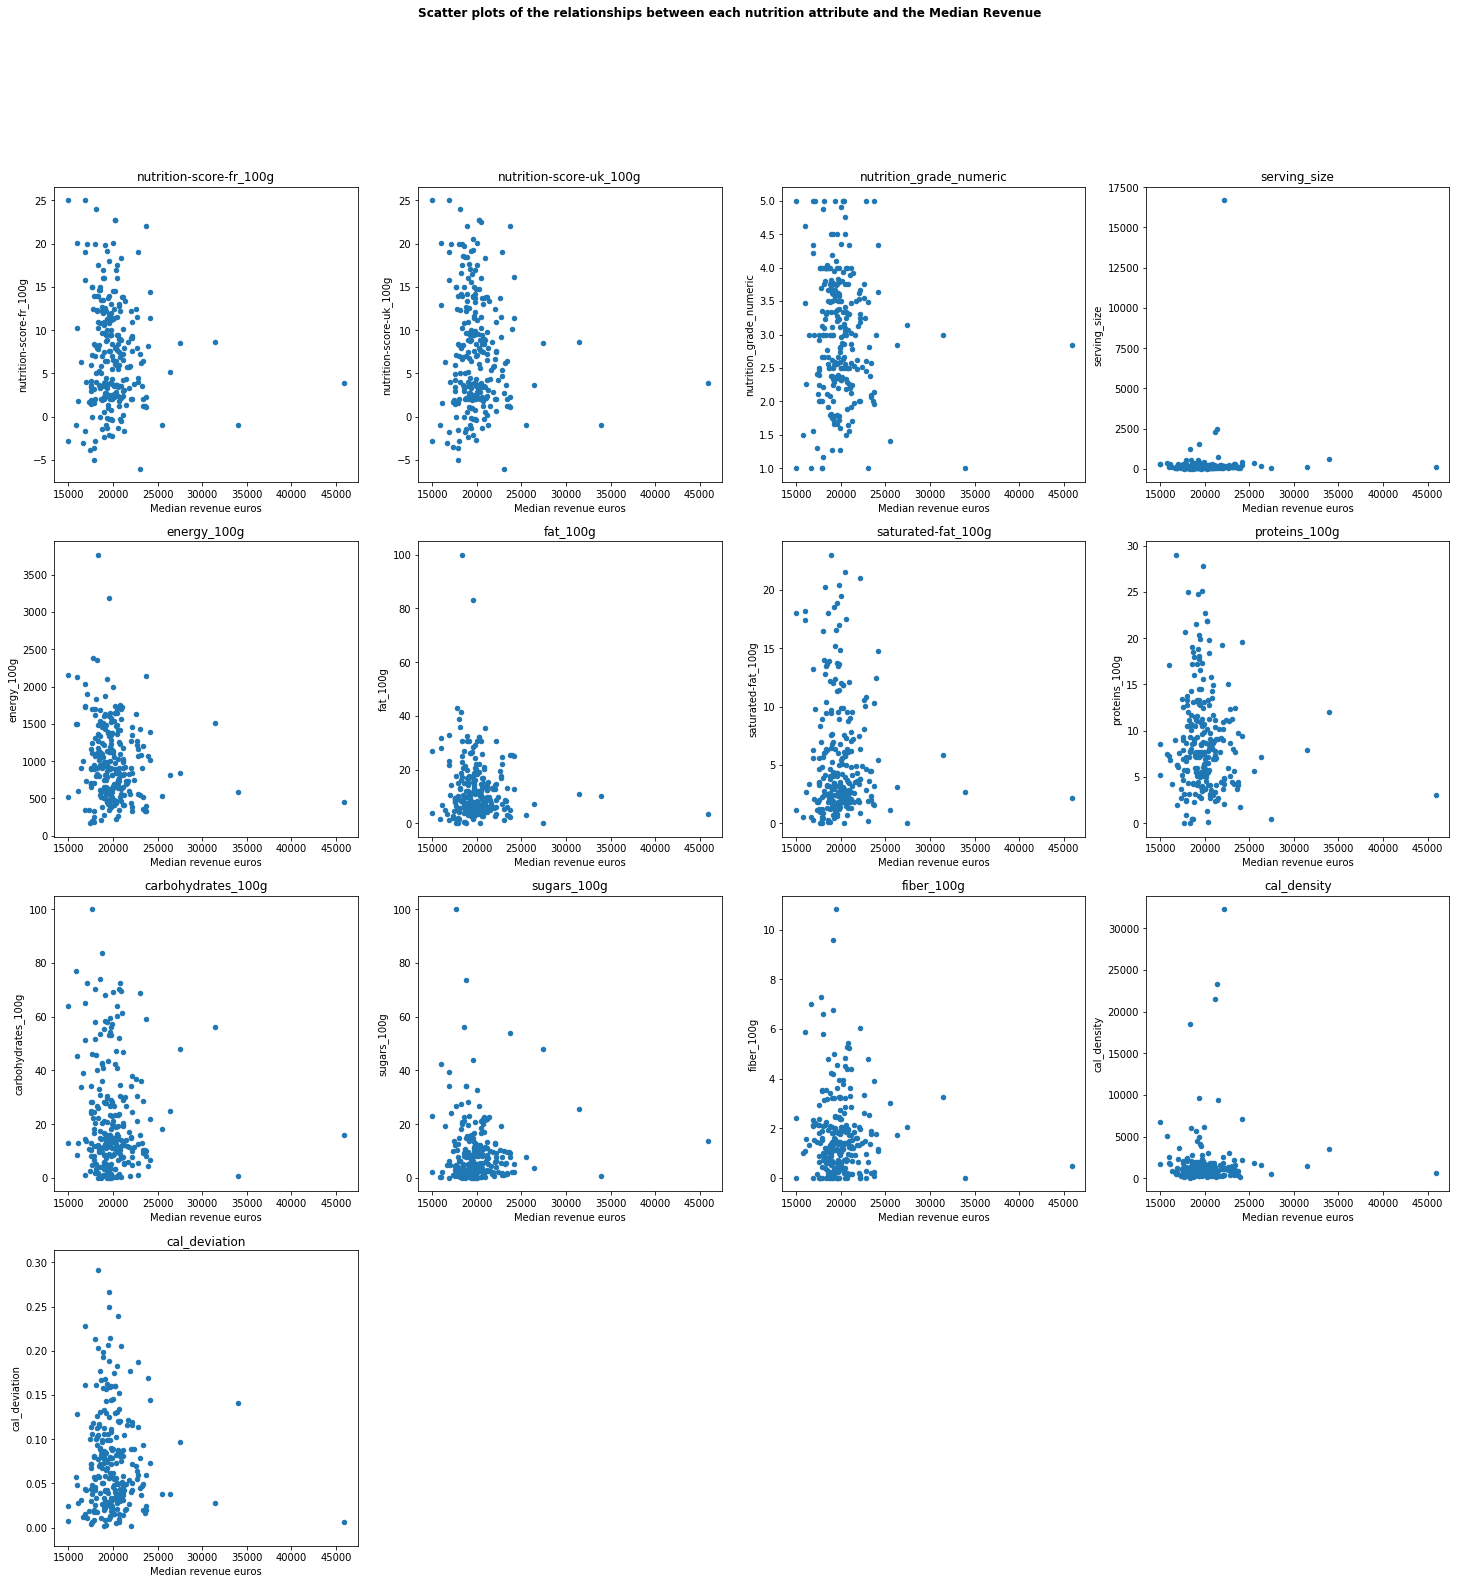

In [192]:
plot_scatter(dataframe_arr)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


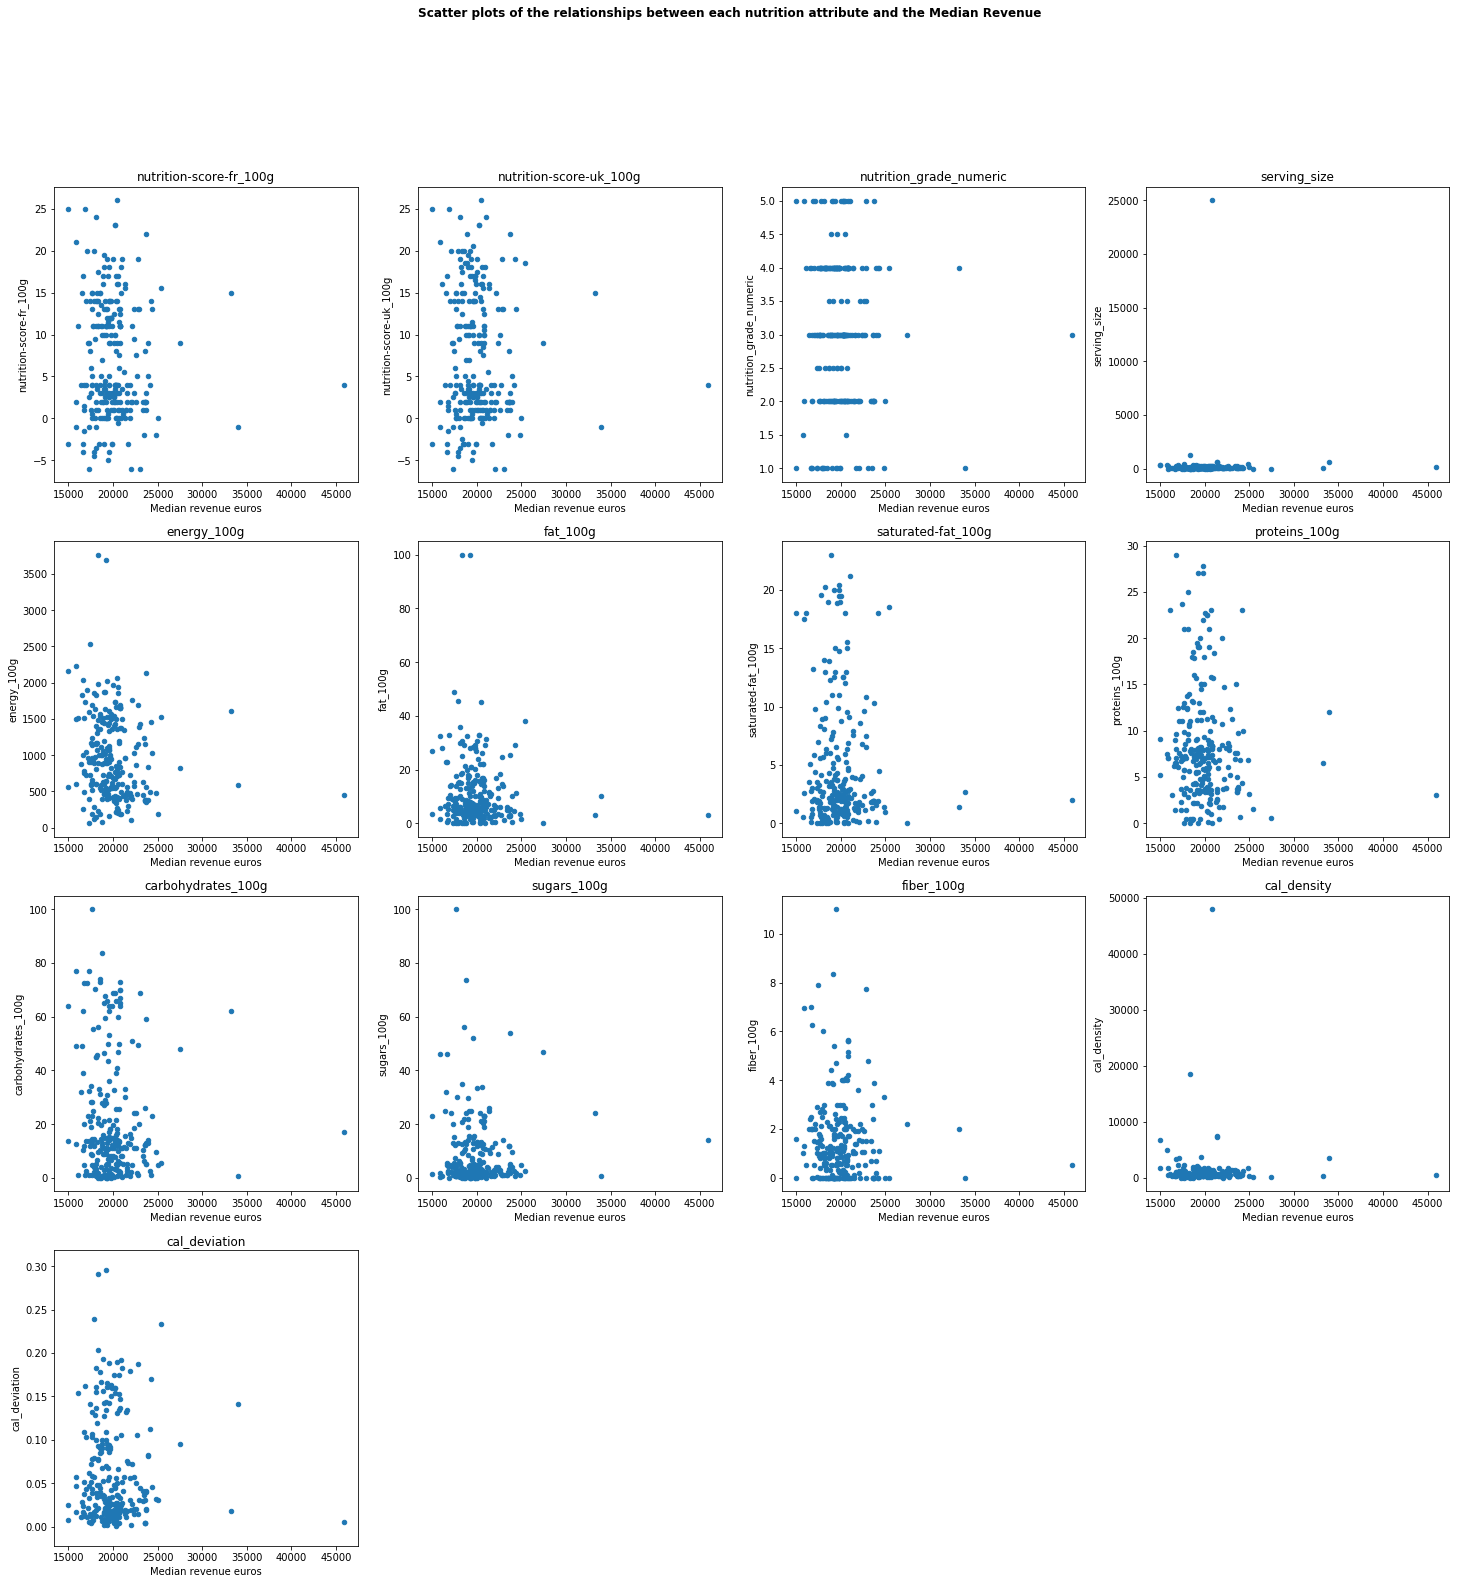

In [193]:
plot_scatter(dataframe_arr_med)

**3. Departments**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


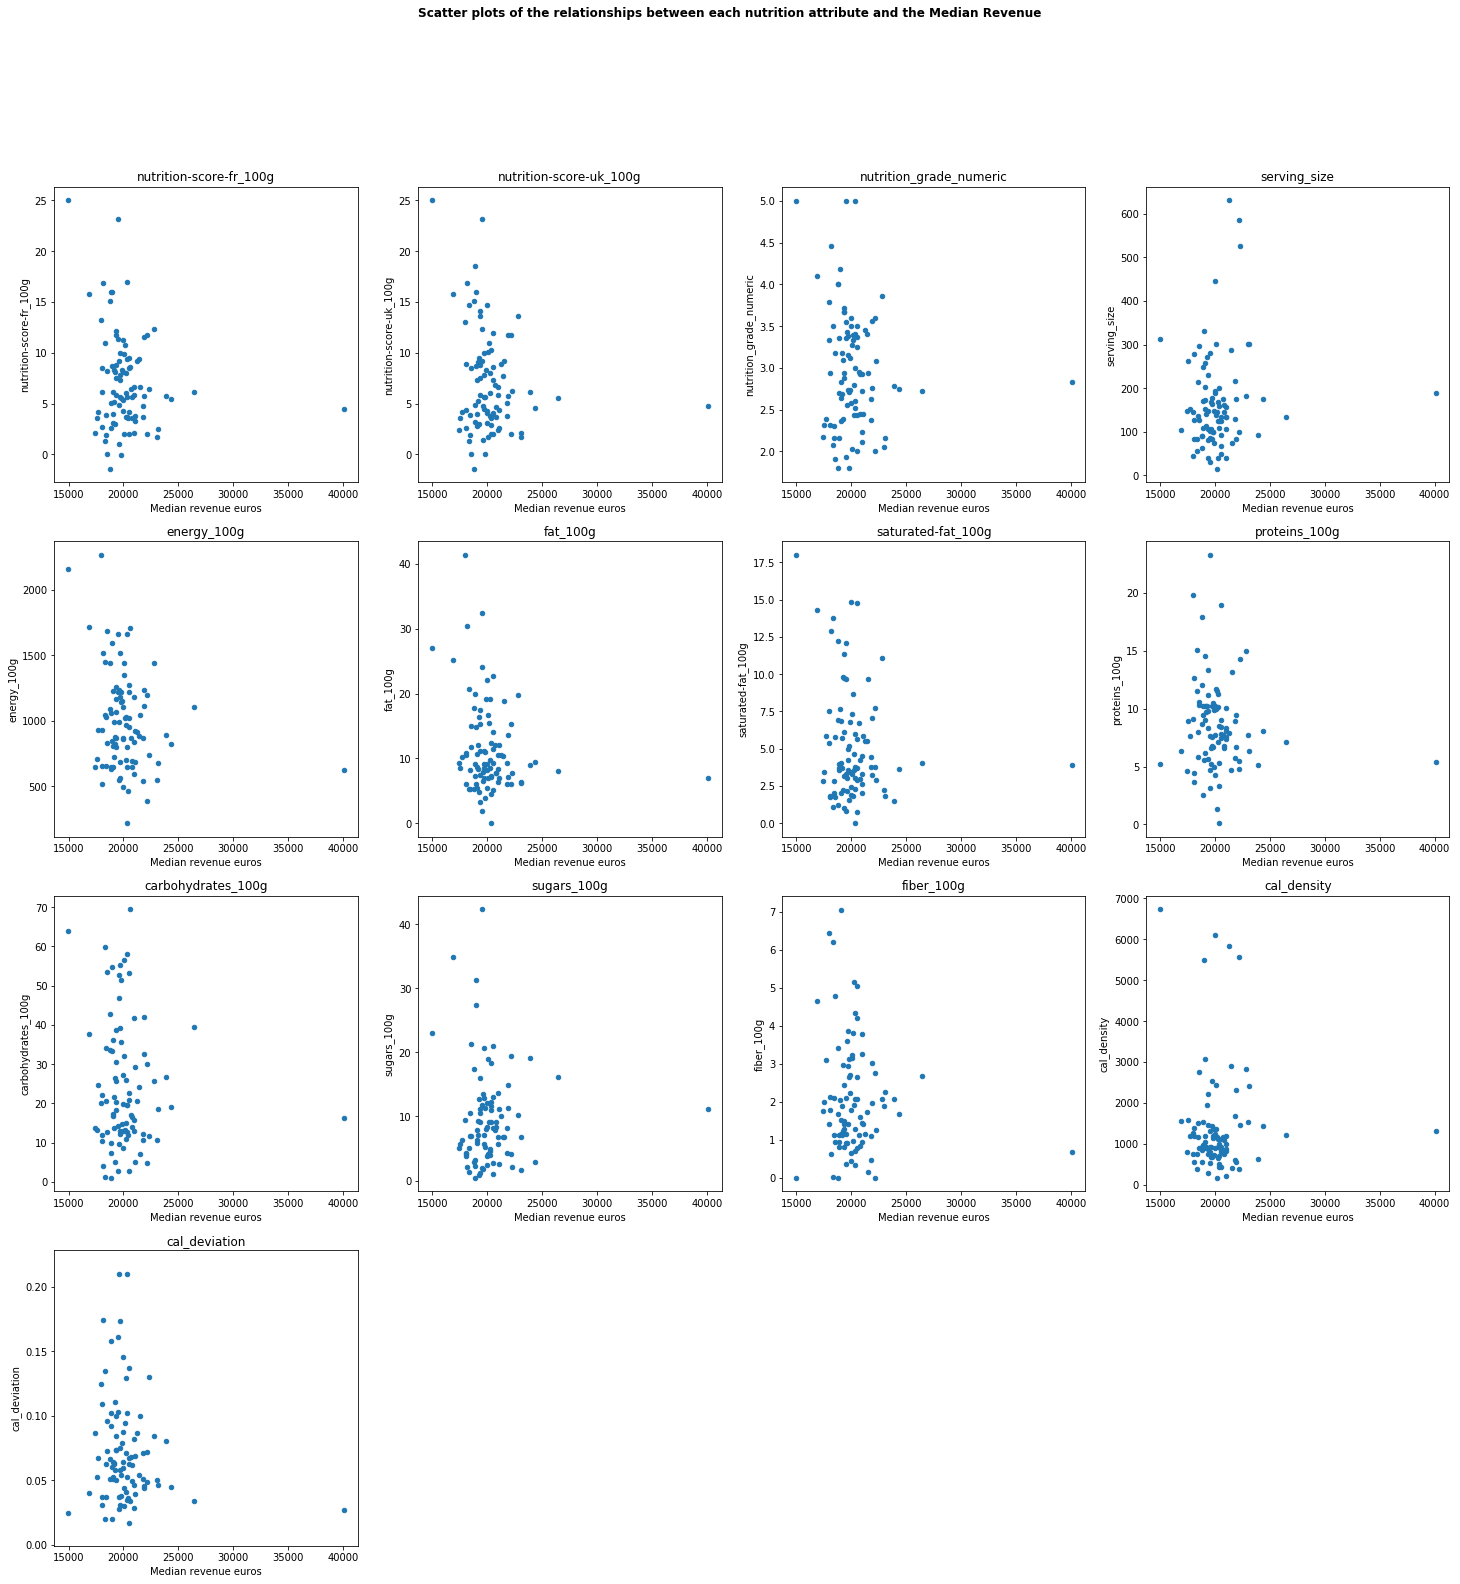

In [194]:
plot_scatter(dataframe_dep)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


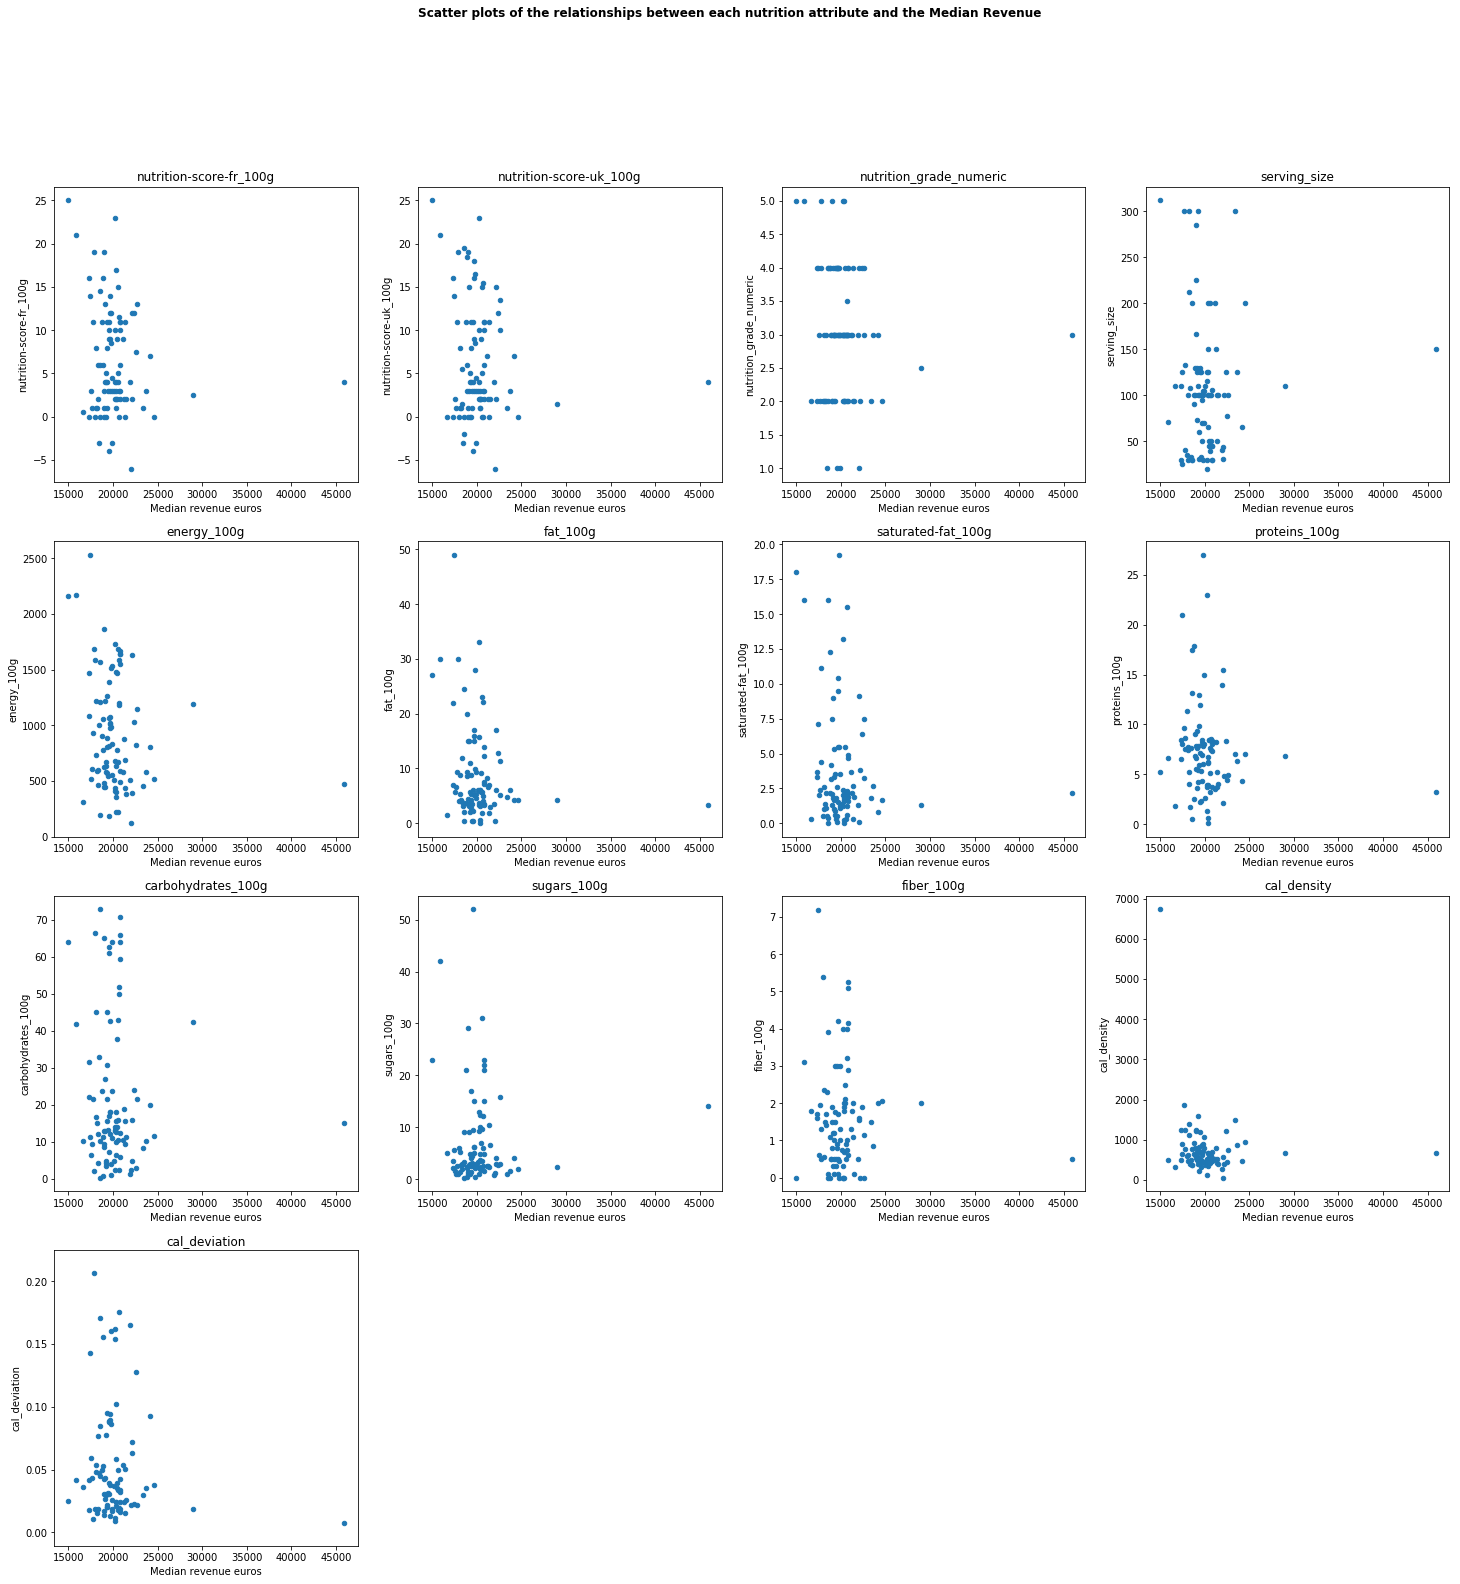

In [195]:
plot_scatter(dataframe_dep_med)

**4. Regions**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


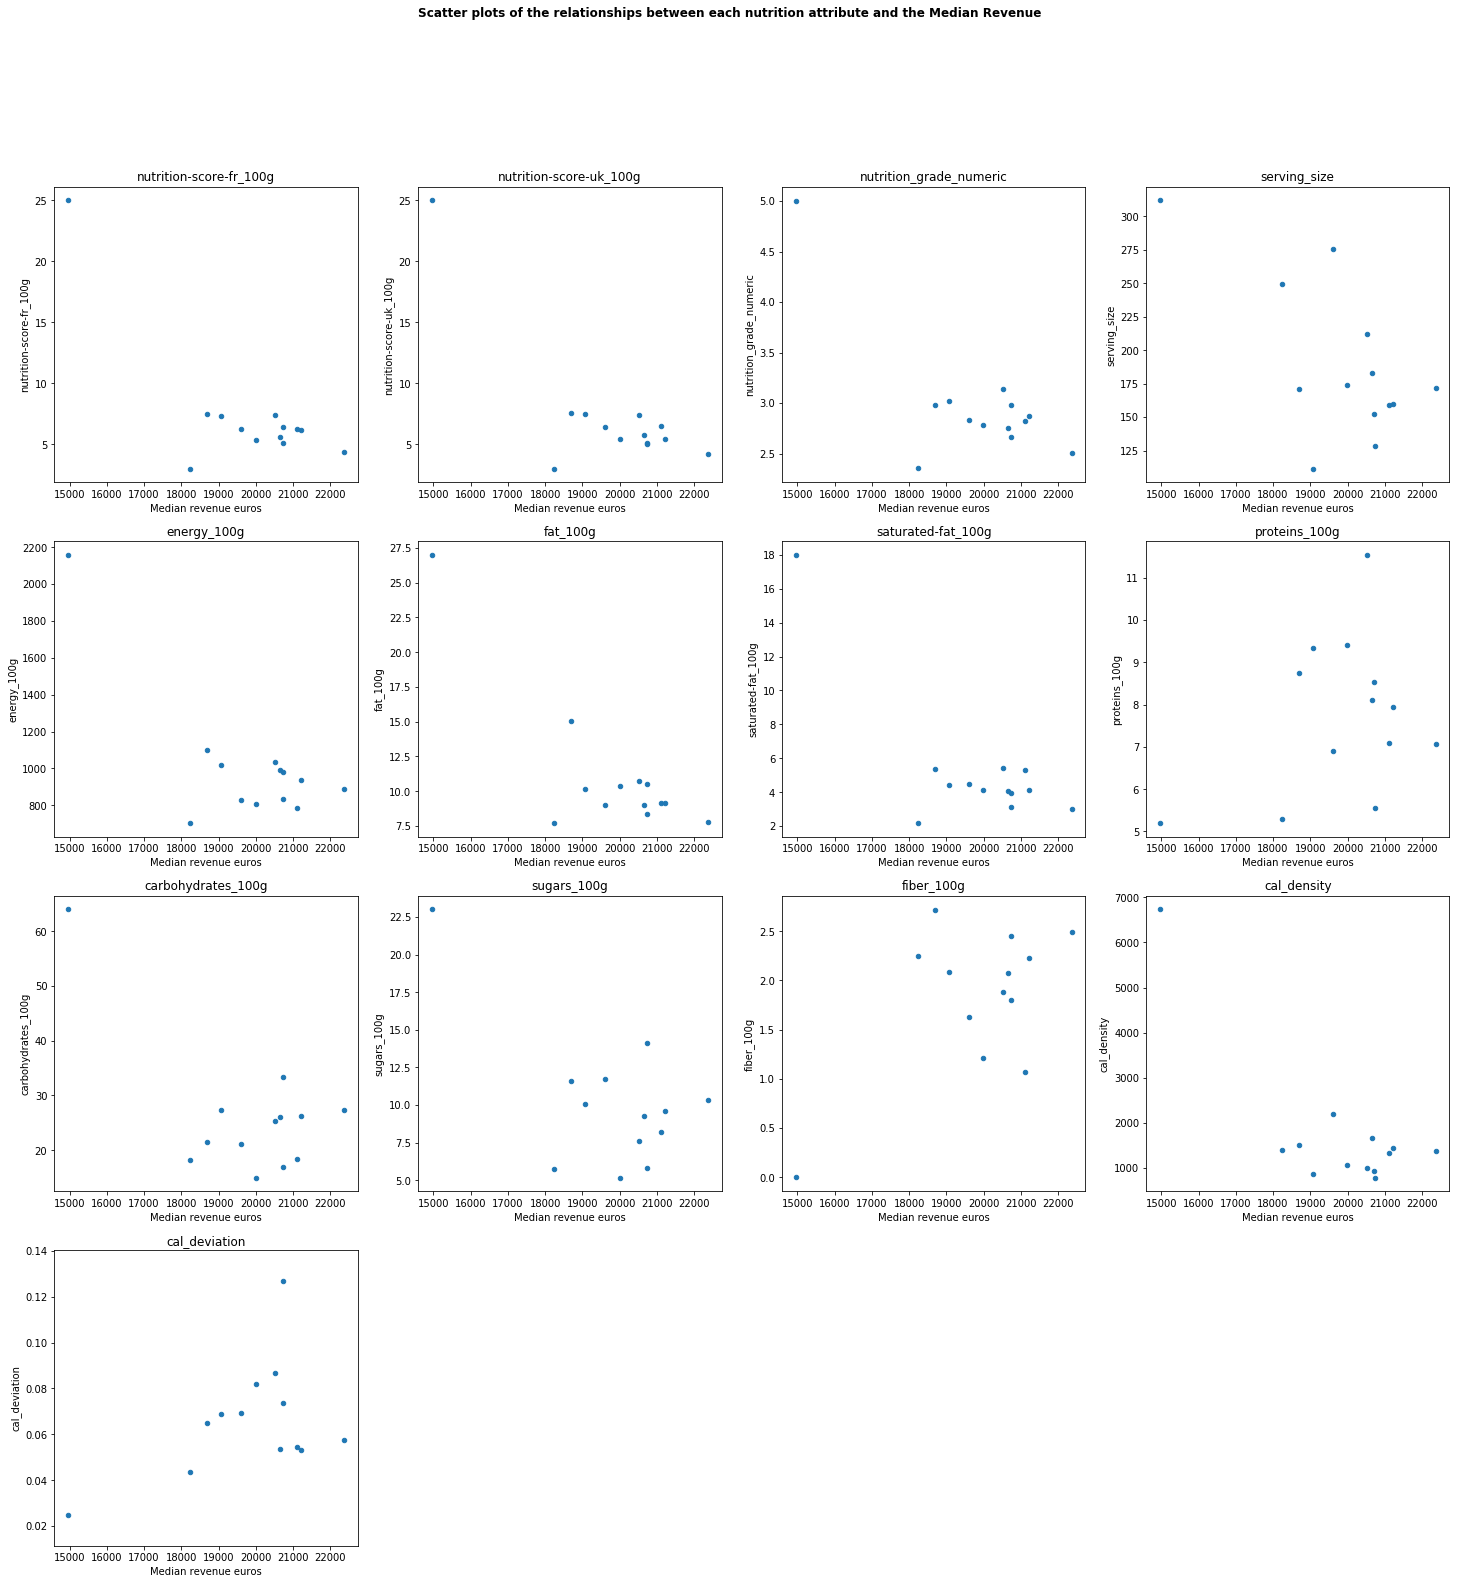

In [196]:
plot_scatter(dataframe_reg)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


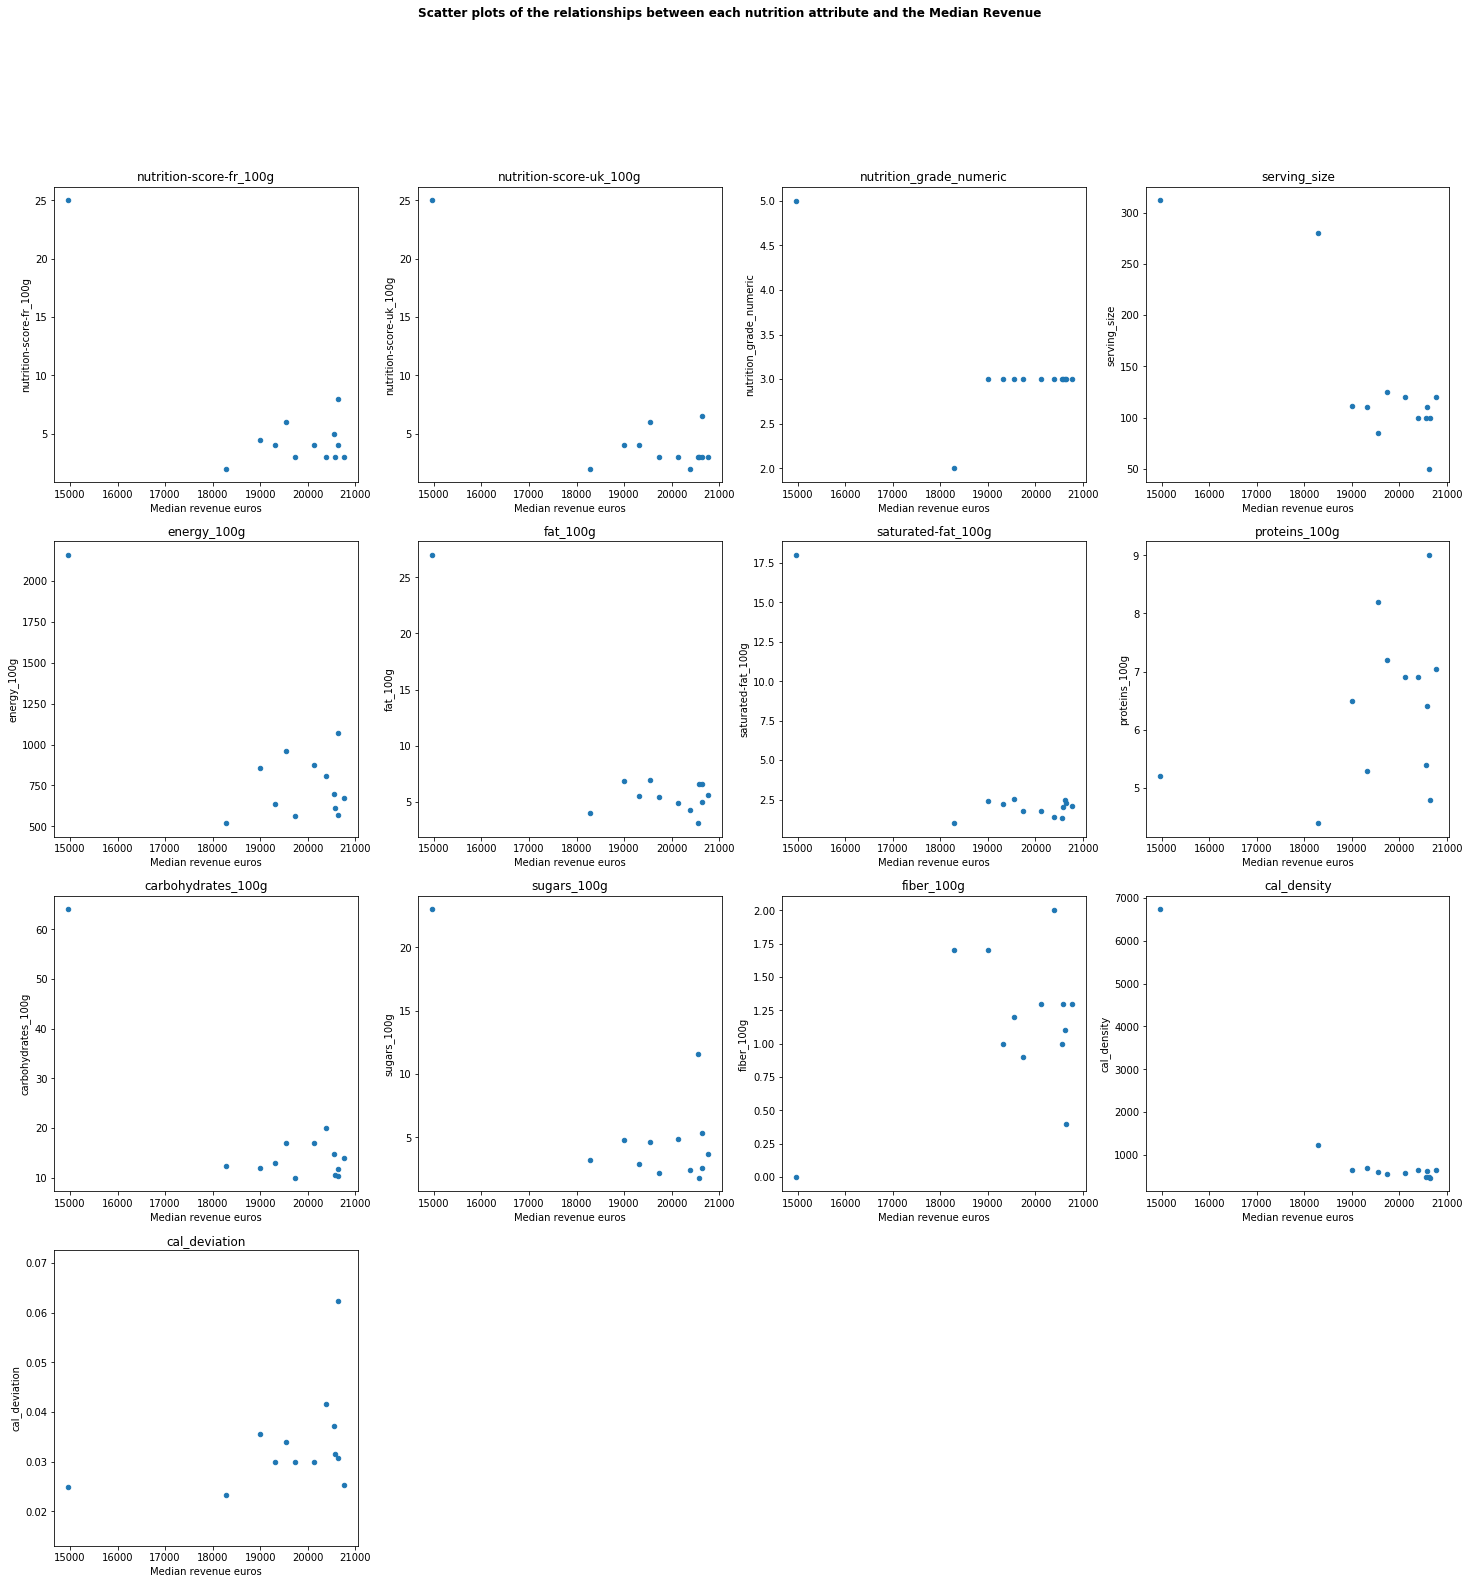

In [197]:
plot_scatter(dataframe_reg_med)

In [201]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels))
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 1
Estimated number of noise points: 115
Silhouette Coefficient: 0.355


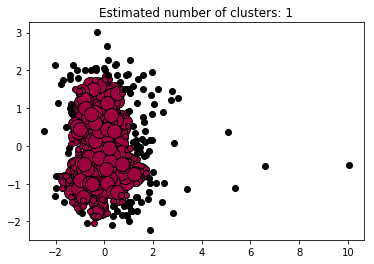

In [202]:
labels = cluster(dataframe_city[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 1
Estimated number of noise points: 74
Silhouette Coefficient: 0.293


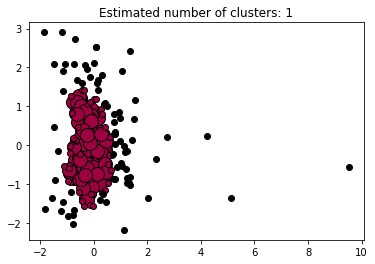

In [203]:
labels = cluster(dataframe_arr[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 2
Estimated number of noise points: 65
Silhouette Coefficient: -0.163


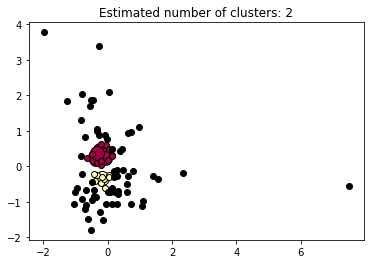

In [204]:
labels = cluster(dataframe_dep[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

Estimated number of clusters: 0
Estimated number of noise points: 13
Silhouette Coefficient could not be computed for 0 clusters


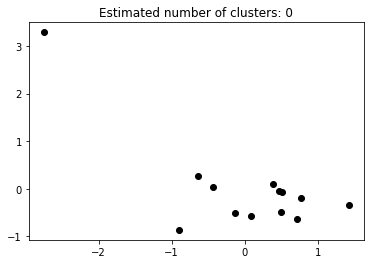

In [205]:
labels = cluster(dataframe_reg[['Median revenue euros', 'energy_100g']], 100, 1)

# 6. Correlation analysis 

In [131]:
def plot_corr_matrix(df1, df2, geography):
    corr1 = df1.corr()
    corr2 = df2.corr()
    names1 = list(corr1.columns)
    names2 = list(corr1.columns)
    # plot correlation matrix
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5.1))
    f.suptitle("Correlation matrix for " + geography, y=1.45, fontweight="bold")
    
    cax1 = ax1.matshow(corr1, vmin=-1, vmax=1)
    ticks1 = np.arange(0, len(names1), 1)
    ax1.set_xticks(ticks1)
    ax1.set_yticks(ticks1)
    ax1.set_xticklabels(names1)
    ax1.set_yticklabels(names1)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Mean', y=1.45)
    
    cax2 = ax2.matshow(corr2, vmin=-1, vmax=1)
    ticks2 = np.arange(0, len(names2), 1)
    ax2.set_xticks(ticks2)
    ax2.set_yticks(ticks2)
    ax2.set_xticklabels(names2)
    ax2.set_yticklabels(names2)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_title('Median', y=1.45)
    
    f.colorbar(cax1)
    plt.show()

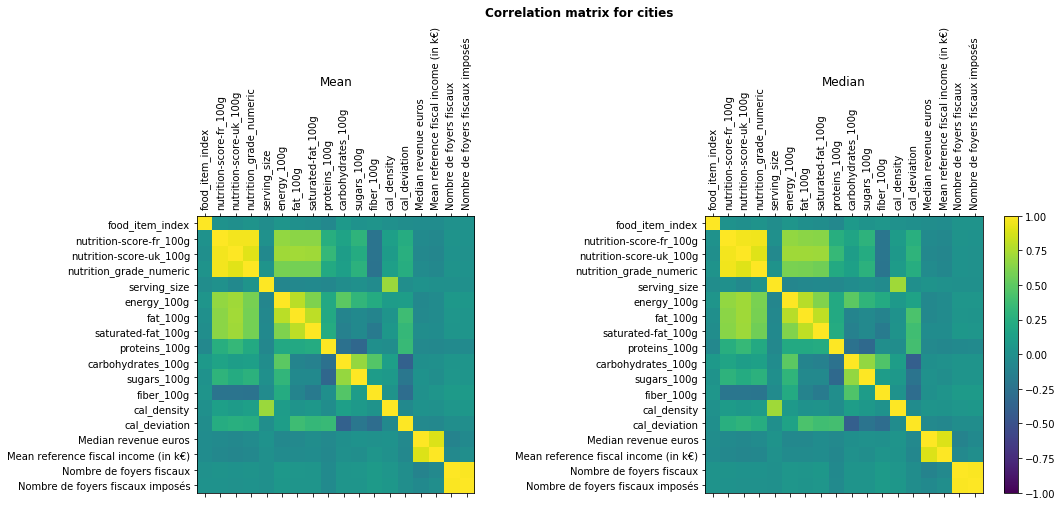

In [132]:
plot_corr_matrix(dataframe_city, dataframe_city_med, "cities")

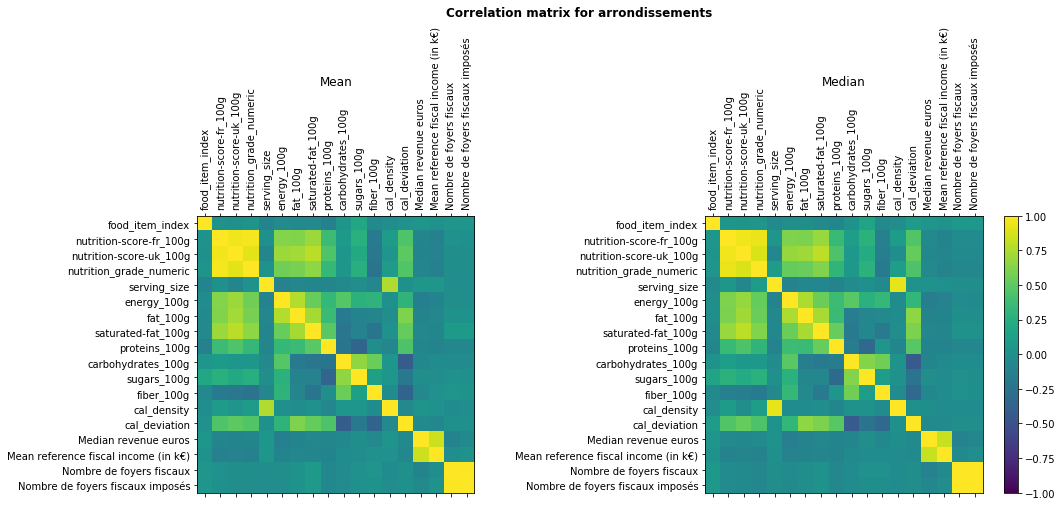

In [133]:
plot_corr_matrix(dataframe_arr, dataframe_arr_med, "arrondissements")

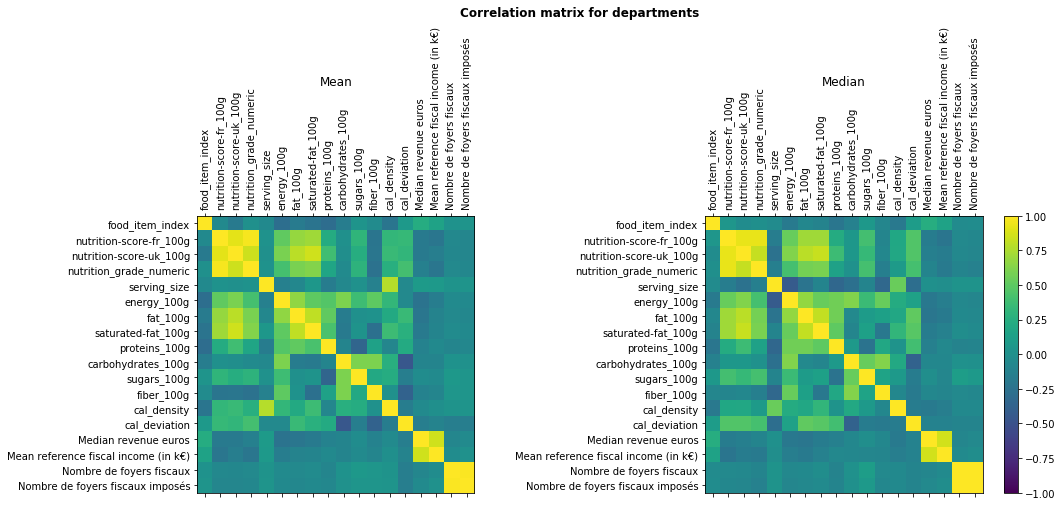

In [134]:
plot_corr_matrix(dataframe_dep, dataframe_dep_med, "departments")

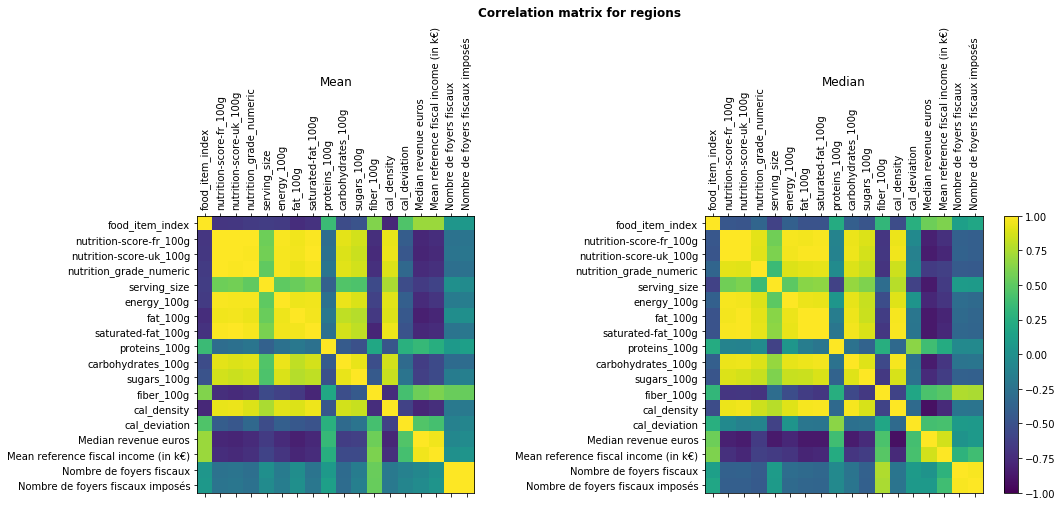

In [135]:
plot_corr_matrix(dataframe_reg, dataframe_reg_med, "regions")

Hooray, we found something at the region level! Let's see more closely how significant it is:

In [136]:
revenue_cols = ['Median revenue euros', 
                'Mean reference fiscal income (in k€)']


In [161]:
def pearson_pval_df(df):
    for col1 in revenue_cols:
        print(col1, ':')
        for col2 in nutritional_columns:
            r, p = stats.pearsonr(df[col2], df[col1])
            p = p*4
            if p < 0.05:
                color = 'green'
            else:
                color = 'red'
            print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col2, 'Pearson coeff', r, 'p-value', p), color))
        print('\n')

In [162]:
pearson_pval_df(dataframe_reg)

Median revenue euros :
nutrition-score-fr_100g                 Pearson coeff   -0.778                      p-value   0.007                         
nutrition-score-uk_100g                 Pearson coeff   -0.792                      p-value   0.005                         
nutrition_grade_numeric                 Pearson coeff   -0.756                      p-value   0.011                         
serving_size                            Pearson coeff   -0.650                      p-value   0.064                         
energy_100g                             Pearson coeff   -0.750                      p-value   0.012                         
fat_100g                                Pearson coeff   -0.824                      p-value   0.002                         
saturated-fat_100g                      Pearson coeff   -0.772                      p-value   0.008                         
proteins_100g                           Pearson coeff   0.340                       p-value   1.022   

In [163]:
pearson_pval_df(dataframe_reg_med)

Median revenue euros :
nutrition-score-fr_100g                 Pearson coeff   -0.815                      p-value   0.003                         
nutrition-score-uk_100g                 Pearson coeff   -0.850                      p-value   0.001                         
nutrition_grade_numeric                 Pearson coeff   -0.653                      p-value   0.062                         
serving_size                            Pearson coeff   -0.858                      p-value   0.001                         
energy_100g                             Pearson coeff   -0.775                      p-value   0.007                         
fat_100g                                Pearson coeff   -0.864                      p-value   0.001                         
saturated-fat_100g                      Pearson coeff   -0.863                      p-value   0.001                         
proteins_100g                           Pearson coeff   0.389                       p-value   0.757   

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition-score-uk_100g  
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density       
* cal_deviation     

For all these columns, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold that allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for sugars, fat, saturated fat, the nutrition scores and the calory density (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies. 

# 7. Vizzzzzzzzz

We only found an actual relationship for regions so this is what we're gonna viz.

First we have to reset the indexes.

In [55]:
dataframe_reg.reset_index(inplace=True)
dataframe_reg_med.reset_index(inplace=True)

Then we have to transform the 'Region' column from int to string and add a 0 if the region number only has one character.

In [56]:
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

Region borders

In [57]:
# geojson: https://github.com/gregoiredavid/france-geojson
reg_borders = json.load(open("../data/raw/regions-avec-outre-mer.geojson"))

And now the viz:

In [58]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(dataframe_reg[column]), np.max(dataframe_reg[column]), 6)
    map_nutrition.choropleth(geo_data=reg_borders, 
                           data=dataframe_reg, 
                           columns=['Region', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [59]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(dataframe_reg['Median revenue euros']), np.max(dataframe_reg['Median revenue euros']), 6)
map_revenue.choropleth(geo_data=reg_borders, 
                       data=dataframe_reg, 
                       columns=['Region', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue euros',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue.save("../data/processed/map_{}.html".format('Median revenue euros'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('Median revenue euros')))